# Jupyter notebook sample

## Parameters and dataset

In [20]:
import os
import ipywidgets as widgets
from IPython.core.display import Markdown
from IPython.display import display

datasets = []

for root, dirs, files in os.walk("./Dataset"):
    for file in files:
        if file.lower().endswith(".txt"):
            datasets.append(os.path.join(root, file))

filename = (
    os.environ["CURRENT_DATASET_FILEPATH"]
    if "CURRENT_DATASET_FILEPATH" in os.environ
    else datasets[0]
)

# Create dropdown
dropdown = widgets.Dropdown(
    options=datasets, value=filename, description="Dataset:", disabled=False
)


# Dropdown event handler
def on_change(change):
    global filename
    filename = change["new"]
    os.environ["CURRENT_DATASET_FILEPATH"] = change["new"]


# Connect the function to the dropdown
dropdown.observe(on_change, "value")

# Display the dropdown
display(Markdown("#### Select Dataset:"))
display(dropdown)
display(Markdown("<br> Re execute notebook after selecting dataset"))


#### Select Dataset:

Dropdown(description='Dataset:', index=2, options=('./Dataset/100/rc108.txt', './Dataset/100/c103.txt', './Dat…

<br> Re execute notebook after selecting dataset

## Fetch and parse data

In [23]:
print(filename)

with open(filename) as file:
    lines = file.readlines()

infos = [int(i) for i in lines[4].split(" ") if len(i) != 0]

vehicle_number, vehicle_capacity = infos[0], infos[1]

lines = lines[9:]

parsed = []

for i in range(len(lines)):
    lines[i] = lines[i].strip()

    if not lines[i]:
        continue

    lines[i] = lines[i].split()

    parsed.append(list(map(int, lines[i])))

parsed

./Dataset/100/r203.txt


[[0, 35, 35, 0, 0, 1000, 0],
 [1, 41, 49, 10, 0, 974, 10],
 [2, 35, 17, 7, 0, 972, 10],
 [3, 55, 45, 13, 0, 967, 10],
 [4, 55, 20, 19, 678, 801, 10],
 [5, 15, 30, 26, 0, 969, 10],
 [6, 25, 30, 3, 415, 514, 10],
 [7, 20, 50, 5, 0, 968, 10],
 [8, 10, 43, 9, 404, 481, 10],
 [9, 55, 60, 16, 400, 497, 10],
 [10, 30, 60, 16, 577, 632, 10],
 [11, 20, 65, 12, 206, 325, 10],
 [12, 50, 35, 19, 0, 975, 10],
 [13, 30, 25, 23, 690, 827, 10],
 [14, 15, 10, 20, 0, 957, 10],
 [15, 30, 5, 8, 175, 300, 10],
 [16, 10, 20, 19, 0, 960, 10],
 [17, 5, 30, 2, 733, 870, 10],
 [18, 20, 40, 12, 0, 974, 10],
 [19, 15, 60, 17, 0, 957, 10],
 [20, 45, 65, 9, 0, 958, 10],
 [21, 45, 20, 11, 0, 971, 10],
 [22, 45, 10, 18, 409, 494, 10],
 [23, 55, 5, 29, 206, 325, 10],
 [24, 65, 35, 3, 0, 960, 10],
 [25, 65, 20, 6, 817, 956, 10],
 [26, 45, 30, 17, 0, 978, 10],
 [27, 35, 40, 16, 104, 255, 10],
 [28, 41, 37, 16, 0, 983, 10],
 [29, 64, 42, 9, 0, 960, 10],
 [30, 40, 60, 21, 259, 354, 10],
 [31, 31, 52, 27, 0, 972, 10],
 [32

## Create dataframe

In [24]:
import pandas as pd

locations = pd.DataFrame(
    parsed, columns=["id", "x", "y", "demand", "ready_time", "due_date", "service"]
)

locations

,id,x,y,demand,ready_time,due_date,service
0,0,35,35,0,0,1000,0
1,1,41,49,10,0,974,10
2,2,35,17,7,0,972,10
3,3,55,45,13,0,967,10
4,4,55,20,19,678,801,10
...,...,...,...,...,...,...,...
96,96,22,27,11,0,974,10
97,97,25,21,12,0,972,10
98,98,19,21,10,0,968,10
99,99,20,26,9,333,432,10


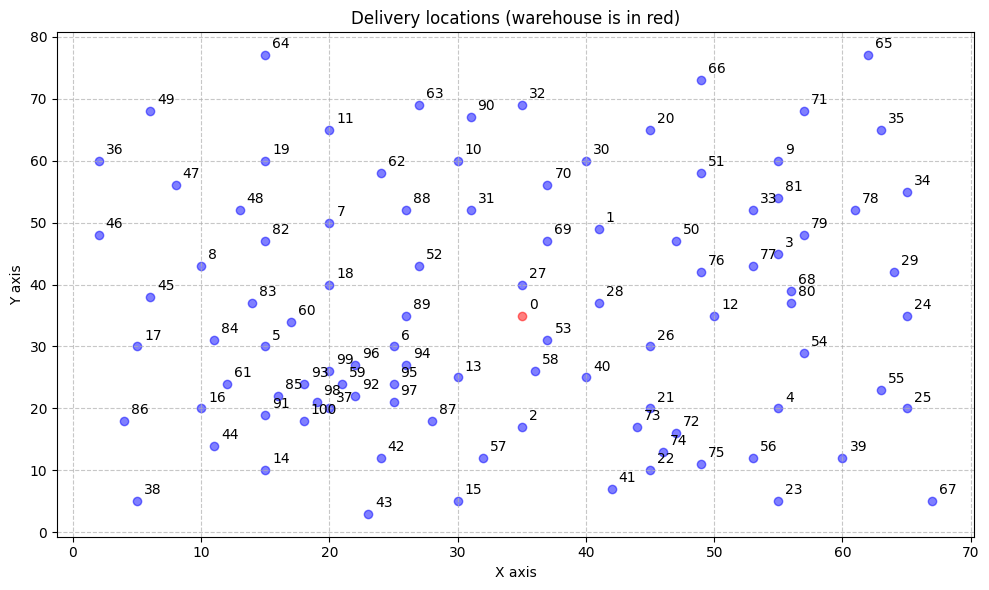

In [25]:
import matplotlib.pyplot as plt

# Create the scatter plot
plt.figure(figsize=(10, 6))

# Draw warehouse
plt.scatter(locations["x"][0], locations["y"][0], c="red", alpha=0.5)

# Draw customers
plt.scatter(locations["x"][1:], locations["y"][1:], c="blue", alpha=0.5)

# Add labels for each point
for i, row in locations.iterrows():
    plt.annotate(
        row["id"],
        (row["x"], row["y"]),
        xytext=(5, 5),  # 5 points offset
        textcoords="offset points",
        fontsize=10,
        ha="left",
    )  # horizontal alignment


# Customize the plot
plt.title("Delivery locations (warehouse is in red)")
plt.xlabel("X axis")
plt.ylabel("Y axis")
plt.grid(True, linestyle="--", alpha=0.7)

# Show the plot
plt.tight_layout()
plt.show()


## Turn into location objects

In [26]:
from src.Location import Location
from src.Vrp import Vrp

locations = [Location(**record) for record in locations.to_dict("records")]

itera = Vrp(locations[0], locations[1:], vehicle_number, vehicle_capacity)

## Compute VRP solution using nearest neighbor

In [ ]:
itera.nearest_neighbor_heuristic().total_cost()

## Compute VRP solution using ant colony optimization


In [ ]:
itera.aco_heuristic(n_ants=50, max_iter=200, alpha=1, beta=1, rho=0.1, plot=True).plot().total_cost()